# Car Prices Prediction

The goal of any business is to make a profit.
Depending on the type of business, various factors can affect profits, including the number of customers. In most situations, an increase in the number of customers leads to an increase in profits.

A service for the sale of used cars is developing an application to attract new customers. In it, you can quickly find out the market value of your car.
Our task is to build such a model for predicting the cost of a car, which will provide the highest quality and fastest prediction.
To build the model, we have historical data at our disposal: technical characteristics, configurations and prices of cars stored in the following csv file: '/datasets/autos.csv'.

From the task, we know that the dataset contains the following information:

**Features**
 + DateCrawled - date of downloading the profile from the database
 + VehicleType - type of car body
 + RegistrationYear — year of car registration
 + Gearbox - type of gearbox
 + Power - power (hp)
 + Model - car model
 + Kilometer - mileage (km)
 + RegistrationMonth - month of car registration
 + FuelType — type of fuel
 + Brand - car brand
 + NotRepaired - was the car under repair or not
 + DateCreated — date of creation of the profile
 + NumberOfPictures - the number of photos of the car
 + PostalCode - postal code of the owner of the profile (user)
 + LastSeen — date of last user activity

**Target feature**
 + Price - price (EUR)


**The purpose of this study** is to prepare a prototype of a machine learning model for the Customer, taking into account the fact that both quality and speed of prediction, as well as training time, are important for them. To assess the quality of the model, we will use the standard metric **RMSE, that is, the square root of the mean squared error**.

**Study progress**:

We will try to build both traditional regression and gradient boosting models by fitting the best hyperparameters, train them and select the best hyperparameters through cross-validation, and then estimate both RMSE and fitting/prediction rate on the test sample.


Thus, this project will include the following steps:
* data preprocessing and data discovery
* building models and training them
* assessment of the quality of the models



## Data Preoprocessing



In [1]:
import numpy as np  # importing numpy
import pandas as pd  # importing pandas
import seaborn as sns # importing seaborn for plotting
import os.path as path # importing os.path for path handling
from sklearn.linear_model import LinearRegression # importing linear regression
import warnings # importing warnings 
warnings.simplefilter("ignore")
from numpy.random import RandomState # importing RandomState
from sklearn.metrics  import  make_scorer # importing for customizing score
import matplotlib.pyplot as plt  # importing matplotlib for plotting
from sklearn.preprocessing import StandardScaler  # importing StandardScaler to scale quantitative features
from sklearn.model_selection import  RandomizedSearchCV # importing RandomSearchCV to search for the best hyperparameters
from sklearn.ensemble import RandomForestRegressor # # importing random forest
from sklearn.dummy import DummyRegressor # importing DummyRegressor for baseline model
from catboost import CatBoostRegressor # importing Catboost
from lightgbm import LGBMRegressor # importing LGBM
from sklearn.model_selection import train_test_split  # importing for splitting dataset
import datetime as dt # importing datetime to hande dates
from sklearn.metrics import mean_squared_error # importing MSE
from sklearn.preprocessing import OrdinalEncoder # importing Ordinal Encoder to handle categorical features
import time # importing time for calculating speed

### Date Overview and Base Preprocessing
Let's make the first idea about the data. To view and analyze, we will read the file in csv format, save them to a variable, and also look at the first 10 lines.



In [2]:
# rading the file and saving to df
try:
    base_path = 'autos.csv' 
    df = pd.read_csv(base_path) if path.exists(base_path) else pd.read_csv(f'/datasets/{base_path}') # checking the path
    display(df.head(10))  # getting 10 first rows
except:
     print('File not found') # if no path is correct, an error message will be printed


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Next, we will get general information about the dataset and check the quality of the data.



In [3]:
df.info() # getting general information on df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

So, from the first overview of the dataset, we can conclude that it contains 16 features, 1 of which ("price") is the target, as well as a very large number of objects - more than 350,000. The dataset has both quantitative and categorical features , the data type for each is as expected. At first glance, it is also clear that there are missing values, we will explore this problem in more detail later.


Next, let's check if there are full duplicates in our dataframe:

In [4]:
df.duplicated().sum()# checking df for full duplicates

4

So, there are full duplicates in our dataframe, there are 4 of them (perhaps, after filling out the ad, one of the clients submitted the form several times due to failures). We shall get rid of them:


In [5]:
df.drop_duplicates(inplace=True) # deleting full duplicates
len(df) # checking the result

354365

Next, let's look at what unique values the categorical features of the dataframe take. As for quantitative ones, precisely because of their nature, they can take on any values, so it makes no sense to carry out such a check:


In [6]:
for f in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']: # iterating over the features
    print(f, df[f].unique()) # visualizing unique values

VehicleType [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Gearbox ['manual' 'auto' nan]
Model ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore'

Next, we will analyze and process missing values in the dataframe:

In [7]:
df.isna().mean() # visualizing the NaN share in each column

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105795
RegistrationYear     0.000000
Gearbox              0.055968
Power                0.000000
Model                0.055607
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092828
Brand                0.000000
NotRepaired          0.200793
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

So, we can notice that in almost 11% of the objects there is no information on the type of body, in 6% on the type of gearbox and model, in 1% on the type of fuel and, finally, in 2% of the objects there is no information on car repair.
As we know, traditional prediction models cannot handle NaNs, so we have to get rid of them.
All features with missing values are categorical, in each of them we will replace NaNs with a certain category, which will mean the absence of data:


In [8]:
df['VehicleType'].fillna('unknown', inplace=True) # filling in missing values in the feature
df['Gearbox'].fillna('noinfo', inplace=True) # filling in missing values in the feature
df['Model'].fillna('nameless', inplace=True) # filling in missing values in the feature
df['FuelType'].fillna('unrevealed', inplace=True) # filling in missing values in the feature
df['NotRepaired'].fillna('incognito', inplace=True) # filling in missing values in the feature

Let's check the preprocessing results:

In [9]:
df.isna().mean() # visualizing the NaN share in each column

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
NotRepaired          0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

Further, in order to exclude possible multicollinearity, we will study the correlation in the quantitative features of the data. To do this, we will present our dataset graphically and analyze whether there is a correlation, and what is its strength between individual features. The value of the correlation between features will be displayed using a heatmap.

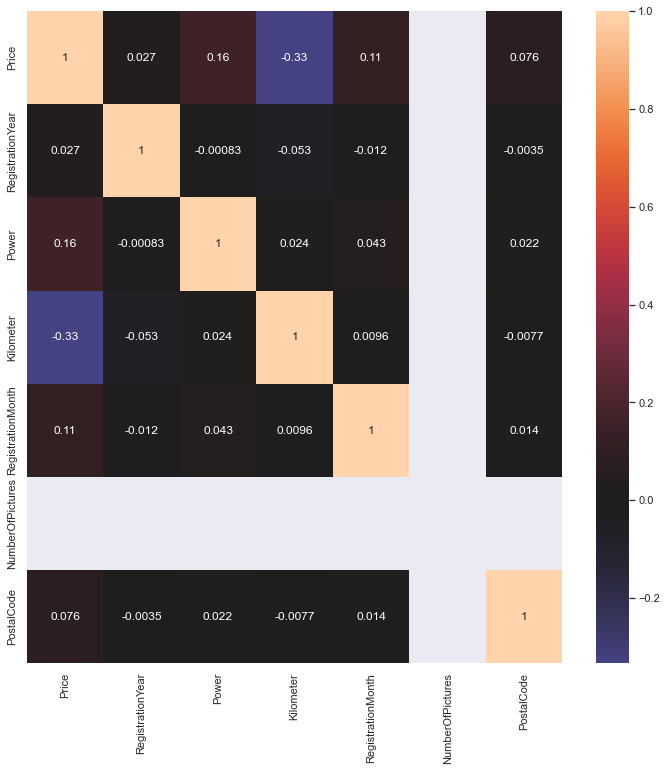

In [10]:
sns.set(rc = {'figure.figsize':(12,12)}) # setting the plot size
sns.heatmap(df.corr(), center=0, annot=True); # plotting  heatmap to assess correlation among the features


So, between the quantitative features in the dataframe, there is both a positive and a negative correlation, but it is weak. The strongest relationship is observed between mileage and price, which is quite predictable: the strength of the relationship of these features is 33 - a fairly moderate value, and its direction is negative.

Also, thanks to the heatmap, we were able to notice an anomaly in the feature "number of pictures", namely: it contains only zero values. Being a constant, this attribute does not affect the cost of the car in any way, so we will simply exclude it from the dataframe:


In [11]:
df.drop(columns=['NumberOfPictures'], inplace=True) # deleting the selected feature

Next, let's take a closer look at the distribution of quantitative features:

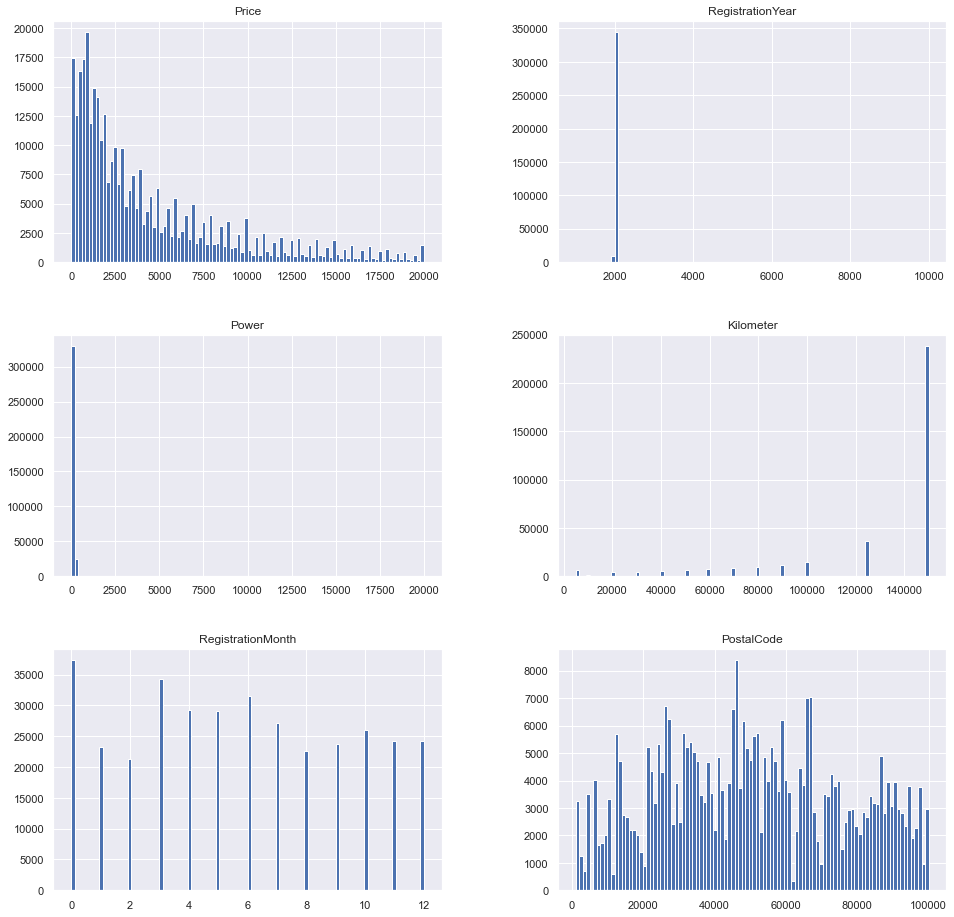

In [12]:
ax = df.hist(bins=100, figsize=(16, 16)); # plotting histogram for each feature


The resulting plots, as well as the size of the scale, suggest that there are anomalous values in the features, namely, in the year and month of registration, the power of the car, and also the price.
Next, we will analyze each of these features separately. Let's start with the price:


In [13]:
df['Price'].describe() # checking for the feature stats

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [14]:
print(len(df[df['Price']==0])) # checking 0 prices
df[df['Price']==0].head(10) # visualizing filtered df

10772


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,unknown,1990,noinfo,0,corsa,150000,1,petrol,opel,incognito,2016-03-26 00:00:00,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,unknown,2017,manual,0,golf,5000,12,petrol,volkswagen,incognito,2016-03-19 00:00:00,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,noinfo,0,nameless,5000,0,petrol,volkswagen,incognito,2016-03-20 00:00:00,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,27432,2016-03-12 23:47:10
154,2016-03-22 16:37:59,0,unknown,2006,noinfo,0,other,5000,0,unrevealed,fiat,incognito,2016-03-22 00:00:00,44867,2016-04-06 06:17:56
231,2016-03-16 22:06:24,0,wagon,2001,manual,115,mondeo,150000,0,unrevealed,ford,incognito,2016-03-16 00:00:00,57627,2016-03-26 11:17:50
334,2016-03-06 10:06:20,0,unknown,2005,noinfo,0,polo,150000,0,petrol,volkswagen,incognito,2016-03-06 00:00:00,35392,2016-03-07 19:12:00
415,2016-03-11 10:52:49,0,unknown,1985,noinfo,0,3er,150000,0,unrevealed,bmw,incognito,2016-03-11 00:00:00,85051,2016-03-11 11:41:09
466,2016-03-24 10:58:40,0,unknown,2016,auto,197,3er,150000,12,gasoline,bmw,no,2016-03-24 00:00:00,99867,2016-03-25 19:46:09


So, the distribution of car prices has a pronounced skew to the right: both the histogram and the arithmetic mean, which is quite much higher than the median due to objects with a high price, testify to this. However, the maximum in the distribution is not that high: 20,000 euros is a reasonable price for a car, in terms of common sense. Much more suspicious are zero prices, which are approx. 3% of the total number of objects. If we pay attention to a certain sample of objects where the price is zero, we will not notice any similarities between them. Taking into account other features of the same objects, from the point of view of common sense, the price of such cars cannot be equal to zero. Most likely, we are talking about errors, and then we will get rid of zero prices in our dataframe, this will make fitting our traditional models better.



In [15]:
df = df.query("Price > 0") # filtering the df
len(df) # checking the result


343593

The next feature that we will analyze is the power of cars:

In [16]:
df['Power'].describe() # visualizing the feature stats

count    343593.000000
mean        110.999665
std         188.178919
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [17]:
print(len(df[(df['Power']==0) | (df['Power'] > 2000)])) # checking the quantity of filtered objects


36474


As far as it concerns the power distribution, in this case the median and the meean are very close to each other, although this is almost imperceptible in the plot due to the scale. And in this case, we can see abnormal values, such as zero power or 20,000 horsepower. We can also assume that these are errors in the data, since the most powerful car in the world at the moment is 10 times weaker than some objects in the dataframe. However, there are too many objects like this(more than 11%), so we cannot simply remove them from the dataset, so we should replace the anomalous feature value by some number, which will allow the model to understand that these values are fictitious or very different.
Let's do this with a function:

In [18]:
# difining a replacement function
def power_replacer(power):
    if power == 0 or power >= 2000:
        return -1111
    return power

In [19]:
df['Power'] = df['Power'].apply(power_replacer) # applying the function to the feature
print(len(df[(df['Power']==0) | (df['Power'] > 2000)])) # checking the quantity of filtered objects

0


Let's move to the month of registration:

In [20]:
df['RegistrationMonth'].unique() # visualizing the feature unique values

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9], dtype=int64)

On the histogram, it was noticeable that among the months there is an anomalous value - 0, moreover, it is the most frequent. Although the month of registration is expressed in numbers, this is a categorical feature, so we will assume that the missing values were replaced by 0, this replacement seems quite adequate, so we will not process this feature further.
Let's look at the year of registration:


In [21]:
sorted(list(df['RegistrationYear'].unique())) # visualizing the feature unique values

[1000,
 1001,
 1039,
 1111,
 1234,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1800,
 1910,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7800,
 8000,
 8200,
 8500,
 8888,
 9000,
 9450,
 9999]

Both from the histogram and from the list of unique values, it is noticeable that there are obviously fantastic values in the dataset, both from the past and from the future. This feature is quantitative, so we will replace the anomalous years with some number, for example, -999, so our model can categorize such values as bogus or, in any case, too different. To do this, let's define a special function:


In [22]:
# defining a replacement function
def year_replacer(year):
    if year < 1910 or year >= 2066:
        return -999
    return year


In [23]:
df['RegistrationYear'] = df['RegistrationYear'].apply(year_replacer) # applying the function to the feature
sorted(list(df['RegistrationYear'].unique())) # visualizing the feature unique values

[-999,
 1910,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019]

Let's look at the dates next. Conventionally, the dates contained in a dataframe should not affect the value of a car, however, machine learning differs from human learning precisely in its ability to find invisible relationships. For this reason, we will not remove the 3 features with dates from our dataframe.
To prepare them for machine learning, we should convert strings to datetime format and then to numeric values. To do this, we use the built-in pandas toordinal() method, which returns the Gregorian serial number of the date:


In [24]:
# changing the dates datatype
for col in ['DateCrawled', 'DateCreated', 'LastSeen']:
    df[col] = pd.to_datetime(df[col])
    df[col]=df[col].map(dt.datetime.toordinal)

    

In [25]:
df.head() # checking the result

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,736047,480,unknown,1993,manual,-1111,golf,150000,0,petrol,volkswagen,incognito,736047,70435,736061
1,736047,18300,coupe,2011,manual,190,nameless,125000,5,gasoline,audi,yes,736047,66954,736061
2,736037,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,incognito,736037,90480,736059
3,736040,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,736040,91074,736040
4,736054,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,736054,60437,736060


**Conclusions**

So, the basic preparation of the data has been done: we got rid of duplicates and missing values that prevent from models building, checked how the features correlate with each other, what unique values they take, and also got rid of unnecessary ones, brought the dates into the format required for machine learning - it's time move on to the next phase of our project.


### Special Data Preparation
Since, according to the assignment, we should build and test traditional regression models, knowing how they work, and also in order to improve the quality of predictions, we should improve the quality of the data. If we only used certain gradient boosting models, special data preparation and even NaNs filling would be redundant.



Further, depending on the models peculiarity, we will duplicate our dataset 2 times and process it accordingly:


In [26]:
df # dataset for gradient boosting
df_forest = df # dataset for random forest
df_linear = df # dataset for linear regression

We will no longer process the gradient boosting sample, so we will proceed to the direct division of the dataframe into samples: training and test, on the latter we will check the quality of the model. When splitting, we will set the random_state parameter to fix the results of the split.


In [27]:
features = df.drop(columns=['Price']) # feature sample
target = df['Price']  # target sample
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345) # splitting the dataset

Let's prepare the dataset for linear regression.

In [28]:
df_linear['Brand'].value_counts().head(10) # checking the top 10 brands

volkswagen       74412
opel             38530
bmw              35809
mercedes_benz    31357
audi             28574
ford             24457
renault          17389
peugeot          10781
fiat              9332
seat              6718
Name: Brand, dtype: int64

In [29]:
df_linear['Model'].value_counts().head(10) # checking the top 10 models

golf        28246
other       23706
3er         19179
nameless    17521
polo        12628
corsa       12197
astra       10475
passat       9834
a4           9642
c_klasse     8174
Name: Model, dtype: int64

In [30]:
# defining a replacement function
def brand_replacer(brand):
    if brand not in ['volkswagen', 'opel', 'bmw', 'mercedes_benz', 'audi', 'ford', 'fiat', 'seat']:
        return 'other'
    return brand

In [31]:
df_linear['Brand'] = df_linear['Brand'].apply(brand_replacer)# applying  the function

In [32]:
# defining a replacement function
def model_replacer(model):
    if model not in ['golf', '3er', 'polo', 'corsa', 'astra', 'passat', 'a4', 'c_klasse']:
        return 'other'
    return model

In [33]:
df_linear['Model'] = df_linear['Model'].apply(model_replacer) # applying  the function

In [34]:
df_linear.head(10) # checking the result

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,736047,480,unknown,1993,manual,-1111,golf,150000,0,petrol,volkswagen,incognito,736047,70435,736061
1,736047,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,736047,66954,736061
2,736037,9800,suv,2004,auto,163,other,125000,8,gasoline,other,incognito,736037,90480,736059
3,736040,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,736040,91074,736040
4,736054,3600,small,2008,manual,69,other,90000,7,gasoline,other,no,736054,60437,736060
5,736058,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,736058,33775,736060
6,736055,2200,convertible,2004,manual,109,other,150000,8,petrol,other,no,736055,67112,736059
8,736058,14500,bus,2014,manual,125,other,30000,8,petrol,ford,incognito,736058,94505,736058
9,736040,999,small,1998,manual,101,golf,150000,0,unrevealed,volkswagen,incognito,736040,27472,736054
10,736049,2000,sedan,2004,manual,105,other,150000,12,petrol,other,no,736049,96224,736060


In [35]:
df_linear_ohe = pd.get_dummies(df_linear, drop_first=True) # encoding categorical features
df_linear_ohe.head() # checking the result

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,PostalCode,LastSeen,VehicleType_convertible,...,Brand_bmw,Brand_fiat,Brand_ford,Brand_mercedes_benz,Brand_opel,Brand_other,Brand_seat,Brand_volkswagen,NotRepaired_no,NotRepaired_yes
0,736047,480,1993,-1111,150000,0,736047,70435,736061,0,...,0,0,0,0,0,0,0,1,0,0
1,736047,18300,2011,190,125000,5,736047,66954,736061,0,...,0,0,0,0,0,0,0,0,0,1
2,736037,9800,2004,163,125000,8,736037,90480,736059,0,...,0,0,0,0,0,1,0,0,0,0
3,736040,1500,2001,75,150000,6,736040,91074,736040,0,...,0,0,0,0,0,0,0,1,1,0
4,736054,3600,2008,69,90000,7,736054,60437,736060,0,...,0,0,0,0,0,1,0,0,1,0


In [36]:
features_linear = df_linear_ohe.drop(columns=['Price']) # feature sample
target_linear = df_linear_ohe['Price']  # target sample
features_train_linear, features_test_linear, target_train_linear, target_test_linear = train_test_split(
    features_linear, target_linear, test_size=0.25, random_state=12345) # splitting the samples

We already know that models based on "distance between features" (Euclidean distance), including linear regression, which we will model, perform better if the features used in training are standardized. For this reason, we will standardize all the quantitative features contained in the dataframe:


In [37]:
numeric = ['RegistrationYear', 'Power', 'Kilometer'] # listing the quantitative features

In [38]:
scaler = StandardScaler() # creating a StandardScaler object
scaler.fit(features_train_linear[numeric]) # fitting StandardScaler
features_train_linear[numeric] = scaler.transform(features_train_linear[numeric]) # scaling train sample
features_test_linear[numeric] = scaler.transform(features_test_linear[numeric]) # scaling test sample


Now it's time to prepare a dataset for random forest:

In [39]:
features_forest = df_forest.drop(columns=['Price']) # feature sample
target_forest = df_forest['Price']  # target sample
features_train_forest, features_test_forest, target_train_forest, target_test_forest = train_test_split(
    features_forest, target_forest, test_size=0.25, random_state=12345) # отделяем 25% данных для тестовой выборки

In [40]:
categoric = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
enc = OrdinalEncoder()
enc.fit(features_train_forest[categoric])
features_train_forest[categoric] = enc.transform(features_train_forest[categoric]) # scaling train sample
features_test_forest[categoric] = enc.transform(features_test_forest[categoric]) # scaling test sample


Next, we will check whether the division into training and test sets occurred in the same way for all 3 datasets:


In [41]:
features_test.head(10) # checking the result

,DateCrawled,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
9166,736044,coupe,2011,manual,184,e_klasse,100000,2,petrol,mercedes_benz,no,736044,45731,736061
288775,736042,wagon,2004,manual,47,fabia,150000,3,gasoline,skoda,no,736042,13086,736046
219263,736058,sedan,2000,manual,105,golf,150000,11,petrol,volkswagen,no,736058,47179,736060
157648,736059,bus,2002,manual,69,transporter,150000,9,gasoline,volkswagen,incognito,736059,2694,736061
29119,736039,wagon,2004,manual,103,stilo,150000,2,petrol,fiat,no,736039,29525,736040
22799,736058,sedan,1989,noinfo,90,80,150000,8,petrol,audi,incognito,736058,32052,736060
251838,736053,bus,1993,auto,121,transporter,150000,12,petrol,volkswagen,no,736053,28239,736061
67125,736057,wagon,2012,manual,140,passat,150000,8,gasoline,volkswagen,no,736057,80939,736059
303840,736043,sedan,2004,manual,75,golf,150000,5,petrol,volkswagen,no,736043,93051,736060
186188,736054,wagon,2005,manual,184,a4,150000,1,gasoline,audi,no,736054,23730,736060


In [42]:
features_test_linear.head(10) # checking the result

,DateCrawled,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,PostalCode,LastSeen,VehicleType_convertible,VehicleType_coupe,...,Brand_bmw,Brand_fiat,Brand_ford,Brand_mercedes_benz,Brand_opel,Brand_other,Brand_seat,Brand_volkswagen,NotRepaired_no,NotRepaired_yes
9166,736044,0.146082,0.503338,-0.755660,2,736044,45731,736061,0,1,...,0,0,0,1,0,0,0,0,1,0
288775,736042,0.033489,0.146533,0.577495,3,736042,13086,736046,0,0,...,0,0,0,0,0,1,0,0,1,0
219263,736058,-0.030850,0.297589,0.577495,11,736058,47179,736060,0,0,...,0,0,0,0,0,0,0,1,1,0
157648,736059,0.001319,0.203830,0.577495,9,736059,2694,736061,0,0,...,0,0,0,0,0,0,0,1,0,0
29119,736039,0.033489,0.292380,0.577495,2,736039,29525,736040,0,0,...,0,1,0,0,0,0,0,0,1,0
22799,736058,-0.207783,0.258523,0.577495,8,736058,32052,736060,0,0,...,0,0,0,0,0,0,0,0,0,0
251838,736053,-0.143444,0.339260,0.577495,12,736053,28239,736061,0,0,...,0,0,0,0,0,0,0,1,1,0
67125,736057,0.162167,0.388744,0.577495,8,736057,80939,736059,0,0,...,0,0,0,0,0,0,0,1,1,0
303840,736043,0.033489,0.219457,0.577495,5,736043,93051,736060,0,0,...,0,0,0,0,0,0,0,1,1,0
186188,736054,0.049574,0.503338,0.577495,1,736054,23730,736060,0,0,...,0,0,0,0,0,0,0,0,1,0


In [43]:
features_test_forest.head(10) # checking the result

,DateCrawled,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
9166,736044,2.0,2011,1.0,184,6.0,100000,2,6.0,4.0,1.0,736044,45731,736061
288775,736042,8.0,2004,1.0,47,6.0,150000,3,2.0,6.0,1.0,736042,13086,736046
219263,736058,4.0,2000,1.0,105,5.0,150000,11,6.0,8.0,1.0,736058,47179,736060
157648,736059,0.0,2002,1.0,69,6.0,150000,9,2.0,8.0,0.0,736059,2694,736061
29119,736039,8.0,2004,1.0,103,6.0,150000,2,6.0,2.0,1.0,736039,29525,736040
22799,736058,4.0,1989,2.0,90,6.0,150000,8,6.0,0.0,0.0,736058,32052,736060
251838,736053,0.0,1993,0.0,121,6.0,150000,12,6.0,8.0,1.0,736053,28239,736061
67125,736057,8.0,2012,1.0,140,7.0,150000,8,2.0,8.0,1.0,736057,80939,736059
303840,736043,4.0,2004,1.0,75,5.0,150000,5,6.0,8.0,1.0,736043,93051,736060
186188,736054,8.0,2005,1.0,184,1.0,150000,1,2.0,0.0,1.0,736054,23730,736060


The indexes match, therefore, the division was made correctly.

**Conclusions:**

So, we have carried out a special pre-processing of the data, which should help us achieve better predictions of traditional models. Let's move on to building them.


## Models

### Traditional Models

So, our goal is to predict the cost of a car. There can be many answers to this question, these will be specific numbers, so our target feature is quantitative, and we are solving a regression problem.
To solve this problem, we will test 2 traditional models: random forest and linear regression. We will check the quality of training by cross-validation, estimating the square root of  mean squared error (RMSE). According to the assignment, this metric should not exceed the value of 2500. In addition, we will fix the fitting rate and prediction rate, since these are important parameters for the Customer.
The results will be presented in a pivot table.


In [44]:
models = ['linear regression', 'random forest', 'catboost', 'lgbm'] # list of models
rmse = [] # list of rmses
fitting_time = [] # list of fitting times
predicting_time =[] # list of predicting times

Let's start with linear regression but first we will define a function to calculate RMSE:

In [45]:
# defining a function to calculate RMSE
def RMSE(target,predictions):
    MSE = mean_squared_error(target, predictions)
    return MSE ** 0.5
RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [46]:
model = LinearRegression()  #  creating a model
param_distributions = {'fit_intercept': [True, False], 'normalize': [True, False]}  #  setting parameters
grid_linear_r = RandomizedSearchCV(model, param_distributions, scoring = RMSE_score, n_jobs=-1) # creating a  RandomSearchCV 
grid_linear_r.fit(features_train_linear, target_train_linear) #  fitting the model
print('RSME лучшей линейной регрессии предсказания стоимости автомобиля', (grid_linear_r.best_score_), 'с параметрами', grid_linear_r.best_params_) # displaying the best result



RSME лучшей линейной регрессии предсказания стоимости автомобиля -3297.4464040200132 с параметрами {'normalize': False, 'fit_intercept': True}


Thus, we found the best linear regression hyperparameters on the training set. Now let's check the quality of predictions on the test set, and also se how long fitting and prediction take:


In [47]:
start_time = time.time()
model =  LinearRegression(normalize=False, fit_intercept=True)  #  creating a model
model.fit(features_train_linear, target_train_linear) # fitting the model
end_time = time.time() - start_time  # calculating the needed time
fitting_time.append(end_time) #  appeding the result
end_time

0.9025189876556396

In [48]:
start_time = time.time()
predictions = model.predict(features_test_linear) # predicting the target
end_time = time.time() - start_time  # calculating the needed time
predicting_time.append(end_time) # appeding the result
end_time

0.03713583946228027

In [49]:
rmse_linear_regression = RMSE(target_test, predictions) # calculating RMSE
rmse.append(rmse_linear_regression) # appeding the resul
rmse_linear_regression

3291.585855350836

Both fitting  and the prediction of linear regression, taking into account the volume of the dataset, are quite fast. However, the square root of the mean squared error is too large - it exceeds the set threshold of 2500. Therefore, this model is not suitable for us.

Next, we construct a traditionally fairly accurate but slow random forest model:


In [50]:
model = RandomForestRegressor(random_state=12345) #  creating a model
param_distributions = {'n_estimators': range (10, 110, 10), 'max_depth': range (1,11)}   #  setting the parameters
grid_forest_r = RandomizedSearchCV(model, param_distributions, scoring=RMSE_score, n_jobs=-1) # creating a  RandomSearchCV
grid_forest_r.fit(features_train_forest, target_train_forest) #  fitting the model
print('RSME лучшего случайного леса предсказания стоимости автомобиля', grid_forest_r.best_score_, 'с параметрами', grid_forest_r.best_params_ ) #  displaying the best result



RSME лучшего случайного леса предсказания стоимости автомобиля -2182.643311334894 с параметрами {'n_estimators': 90, 'max_depth': 7}


The optimal random forest parameters for our data have been found. Now let's test its quality and speed:


In [51]:
start_time = time.time()
model =  RandomForestRegressor(random_state=12345, n_estimators=90, max_depth=10)  #  creating a model
model.fit(features_train_forest, target_train_forest) #  fitting the model
end_time = time.time() - start_time  # calculating the needed time
fitting_time.append(end_time) # appeding the resul
end_time

137.85254883766174

In [52]:
start_time = time.time()
predictions = model.predict(features_test_forest) # predicting the target
end_time = time.time() - start_time  # calculating the needed time
predicting_time.append(end_time) # appeding the resul
end_time

1.503993034362793

In [53]:
rmse_random_forest = RMSE(target_test_forest, predictions) # calculating RMSE
rmse.append(rmse_random_forest) # appeding the resul
rmse_random_forest

1941.2782261048176

So, the random forest prediction quality metric satisfies the threshold set in the task, but the speed leaves much to be desired on such a large dataset.


### Gradient Boosting

Further, we will start gradient boosting models. Let's start with CatBoost:

In [54]:
model = CatBoostRegressor(random_seed=12345) #  creating a model
param_distributions = {'iterations': range (10, 110, 10), 'max_depth': range (1,11), 'learning_rate': [0.1, 0.2, 0.3]}   #  setting the parameters
clf_b = RandomizedSearchCV(model, param_distributions, scoring=RMSE_score, n_jobs=-1) # creating a  RandomSearchCV
clf_b.fit(features_train, target_train, cat_features=categoric, verbose=10) #  fitting the model
print('RSME лучшего Catboost предсказания стоимости автомобиля', clf_b.best_score_, 'с параметрами', clf_b.best_params_ ) # # displaying the best result



0:	learn: 3633.9232590	total: 469ms	remaining: 46.4s
10:	learn: 1908.9882962	total: 3.31s	remaining: 26.8s
20:	learn: 1791.1275679	total: 6.02s	remaining: 22.7s
30:	learn: 1721.6983283	total: 8.76s	remaining: 19.5s
40:	learn: 1685.7027497	total: 11.5s	remaining: 16.5s
50:	learn: 1652.7758708	total: 14.2s	remaining: 13.6s
60:	learn: 1626.3143711	total: 16.7s	remaining: 10.7s
70:	learn: 1606.8391584	total: 19.3s	remaining: 7.9s
80:	learn: 1586.4584762	total: 22.1s	remaining: 5.17s
90:	learn: 1568.9705716	total: 24.7s	remaining: 2.45s
99:	learn: 1554.2640821	total: 27.2s	remaining: 0us
RSME лучшего Catboost предсказания стоимости автомобиля -1666.2172980067287 с параметрами {'max_depth': 9, 'learning_rate': 0.3, 'iterations': 100}


In [55]:
start_time = time.time()
model =  CatBoostRegressor(random_seed=12345, max_depth=8, learning_rate=0.3, iterations=90)  #  creating a model
model.fit(features_train, target_train, cat_features=categoric, verbose=10) #  fitting the model
end_time = time.time() - start_time  # calculating the needed time
fitting_time.append(end_time) # appeding the resul
end_time

0:	learn: 3649.5343354	total: 298ms	remaining: 26.5s
10:	learn: 1945.5660855	total: 2.66s	remaining: 19.1s
20:	learn: 1821.8570007	total: 4.87s	remaining: 16s
30:	learn: 1761.2689743	total: 7.26s	remaining: 13.8s
40:	learn: 1722.1021232	total: 9.63s	remaining: 11.5s
50:	learn: 1697.0120192	total: 11.9s	remaining: 9.14s
60:	learn: 1670.5926872	total: 14.3s	remaining: 6.8s
70:	learn: 1651.9131569	total: 16.6s	remaining: 4.46s
80:	learn: 1636.2204202	total: 18.8s	remaining: 2.09s
89:	learn: 1624.2571732	total: 20.8s	remaining: 0us


22.7288498878479

In [56]:
start_time = time.time()
predictions = model.predict(features_test) # predicting the target
end_time = time.time() - start_time  # calculating the needed time
predicting_time.append(end_time) # appeding the result
end_time

0.4968574047088623

In [57]:
rmse_catboost = RMSE(target_test, predictions) # calculating RMSE
rmse.append(rmse_catboost) # appeding the result
rmse_catboost

1649.9422895988525

CatBoost results are much better than random forest results, and most importantly, fitting and prediction are much faster.
Next, we will test the LGBMR model, but first we will change the type of categorical features of our dataframe:


In [58]:
# changing the datatype of the categorical features
for col in categoric:
    features_train[col] = features_train[col].astype('category')
    features_test[col] = features_test[col].astype('category')
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257694 entries, 54218 to 224485
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   DateCrawled        257694 non-null  int64   
 1   VehicleType        257694 non-null  category
 2   RegistrationYear   257694 non-null  int64   
 3   Gearbox            257694 non-null  category
 4   Power              257694 non-null  int64   
 5   Model              257694 non-null  category
 6   Kilometer          257694 non-null  int64   
 7   RegistrationMonth  257694 non-null  int64   
 8   FuelType           257694 non-null  category
 9   Brand              257694 non-null  category
 10  NotRepaired        257694 non-null  category
 11  DateCreated        257694 non-null  int64   
 12  PostalCode         257694 non-null  int64   
 13  LastSeen           257694 non-null  int64   
dtypes: category(6), int64(8)
memory usage: 19.4 MB


In [59]:
model =  LGBMRegressor(random_seed=12345) #  creating a model
param_distributions = {'n_estimators': range (10, 110, 10), 'num_leaves': [10,20,31], 'max_depth': range (1,11), 'learning_rate': [0.1, 0.2, 0.3]}   #  setting the parameters
clf_l = RandomizedSearchCV(model, param_distributions, scoring=RMSE_score, n_jobs=-1) # creating a  RandomSearchCV
clf_l.fit(features_train, target_train) #  fitting the model
print('RSME лучшего LGBM предсказания стоимости автомобиля', clf_l.best_score_, 'с параметрами', clf_l.best_params_ ) #  displaying the best result




RSME лучшего LGBM предсказания стоимости автомобиля -1665.9614565565867 с параметрами {'num_leaves': 31, 'n_estimators': 70, 'max_depth': 10, 'learning_rate': 0.2}


In [60]:
start_time = time.time()
model =  LGBMRegressor(random_seed=12345, num_leaves = 20, max_depth=10, learning_rate=0.2, n_estimators=100) #  creating a model
model.fit(features_train, target_train) #  fitting the model
end_time = time.time() - start_time  # calculating the needed time
fitting_time.append(end_time) # appeding the result
end_time 

2.09995698928833

In [61]:
start_time = time.time()
predictions = model.predict(features_test) # predicting the target
end_time = time.time() - start_time # calculating the needed time
predicting_time.append(end_time) # appeding the result
end_time 

0.4350450038909912

In [62]:
rmse_lgbm = RMSE(target_test, predictions) # calculating RMSE
rmse.append(rmse_lgbm) # appeding the result
rmse_lgbm

1634.9509013525317

So, LGBMR showed an even higher result on our sample, an even higher fitting rate and a slightly lower prediction rate than CatBoost.


So, before making the final choice, we will compile a summary table for all models, and also compare the results of the leader with a constant model.


In [63]:
# creating a summary df with the results
Models = pd.DataFrame({'fitting_time': fitting_time, 'predicting_time': predicting_time, 'rmse': rmse}, index=models)
Models


,fitting_time,predicting_time,rmse
linear regression,0.902519,0.037136,3291.585855
random forest,137.852549,1.503993,1941.278226
catboost,22.728850,0.496857,1649.942290
lgbm,2.099957,0.435045,1634.950901


In [64]:
dummy_regr_r = DummyRegressor(strategy="mean") # creating a model
dummy_regr_r.fit(features_train, target_train) #  fitting the model
dummy_predictions = dummy_regr_r.predict(features_test) # predicting the target

In [65]:
rmse_dummy = RMSE(target_test, dummy_predictions) # calculating RMSE
rmse_dummy

4507.906941262256

So, the constant model showed a different from all other models, and most importantly, the worst result. Therefore, the model is adequate and can go into production.


## Study Results 
In the course of this study, we prepared and analyzed the data, as a result of which we managed to get rid of duplicates, missing and abnormal values, then we prepared 3 datasets with different levels of data preparation for 3 groups of regression models

We checked the results of model fitting by cross-validation, choosing the optimal hyperparameters.
According to the results of the comparison, it turned out that the most **qualitatively (with a minimum RMSE value) and quickly the cost of a car in our sample is predicted by gradient boosting, namely, LGMB.**

Perhaps the result would be even better if we applied alternative regression models not yet known to us.
